In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os

In [16]:
# Filter global dataset by first row transition & annotated data
df_mof_full = pd.read_csv('/scratch/yll6162/MOF-oxo/labels/id_prop_full.csv')
df_annoted_mof = pd.read_csv('/scratch/yll6162/MOF-oxo/labels/baremof_rem_inf_out.csv')
df_mof_query = df_mof_full[~df_mof_full['id'].isin(df_annoted_mof['MOF'])]
df_fea = pd.read_csv("./mof_features/Features_RACS.csv", index_col=0)
df_mof_query = df_mof_query.merge(df_fea[['MOF Name','Metal_index', 'Metal']], how='inner', left_on=['id'], right_on = ['MOF Name'])
df_mof_query_first_row = df_mof_query[df_mof_query.Metal.isin(['Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu'])]
# Get a list of files to copy based on the DataFrame
files_to_copy = df_mof_query_first_row['file'].values
source_folder = "/scratch/yll6162/MOF-oxo/MOFs_oms"
destination_folder = "/scratch/yll6162/MOF-oxo/MOFs_oms_unlabel_pool"
# Iterate over files in the source folder
for file_name in os.listdir(source_folder):
    if file_name in files_to_copy:
        # Construct full paths for source and destination files
        source_file = os.path.join(source_folder, file_name)
        destination_file = os.path.join(destination_folder, file_name)
        # Copy the file to the destination folder
        shutil.copyfile(source_file, destination_file)
# this one is for pre-processing.ipynb
df_mof_query_first_row.drop(columns=["MOF Name", "Metal_index","Metal"]).drop_duplicates().to_csv("/scratch/yll6162/MOF-oxo/MOFs_oms/id_prop_oxo_unlabel.csv", index=None)
# this one is for features.ipynb
df_mof_query_first_row.to_csv("/scratch/yll6162/MOF-oxo/labels/id_prop_unlabel.csv", index=None)


1.2765166343215433
0.9741620262374799
    std_sum  row_std_oxo  row_std_h
0  1.124873     0.797472   0.487225
1  1.006098     0.555773   0.555969
2  0.884269     0.493838   0.484554
3  0.881402     0.459860   0.507690
4  0.842700     0.471163   0.461363


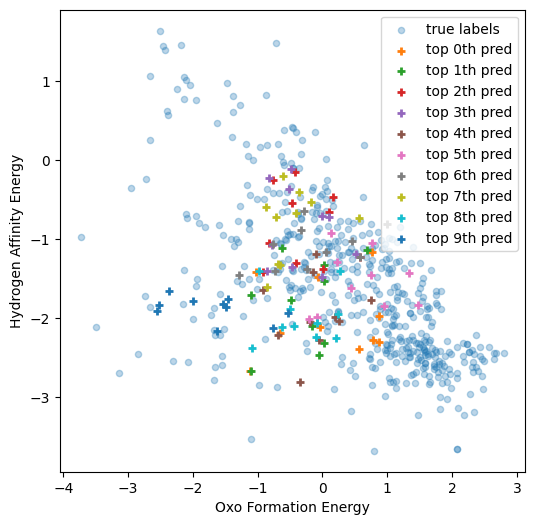

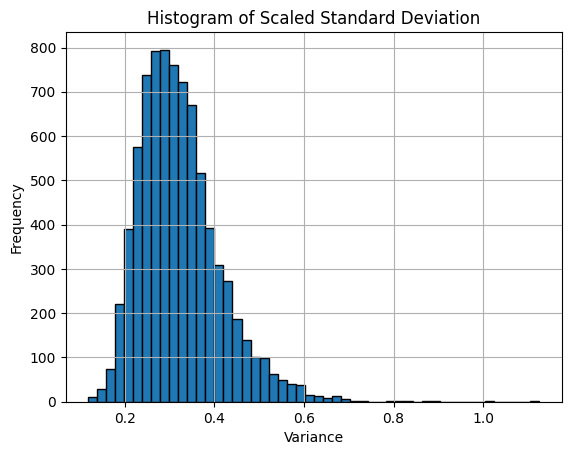

In [23]:
prop = "oxo"
# algo = "dband_racs_tl"
algo = "rf"
run_idx = 1
file_path = f"/scratch/yll6162/MOF-oxo/output/{algo}_pred_{prop}_idx_iter_all_var_query_{run_idx}.csv"
df_var_oxo = pd.read_csv(file_path, index_col = 0)
prop = "h"
file_path = f"/scratch/yll6162/MOF-oxo/output/{algo}_pred_{prop}_idx_iter_all_var_query_{run_idx}.csv"
df_var_h = pd.read_csv(file_path, index_col = 0)

df_var = df_var_h.merge(df_var_oxo, how='inner', on='ids_test', suffixes = ['_h','_oxo'])

# df_var["var_sum"] = df_var["row_variances_oxo"] + df_var["row_variances_h"]
# src_file_path = "/scratch/yll6162/MOF-oxo/labels/baremofdf_rem_inf_and_NN.csv"
src_file_path = "/scratch/yll6162/MOF-oxo/labels/Combined_Energies_Removed_Infeasible_Out.csv"
df_src = pd.read_csv(src_file_path, index_col = 0)

# global_oxo_std = np.std(df_var_oxo.drop(columns = ["ids_test"]).values)
global_oxo_std = np.std(df_src["Oxo Formation Energy"].values)
global_h_std = np.std(df_src["Hydrogen Affinity Energy"].values)
# global_h_std = np.std(df_var_h.drop(columns = ["ids_test"]).values)
df_var['std_sum'] =  df_var["row_std_oxo"] / global_oxo_std + df_var["row_std_h"] / global_h_std
df_var = df_var.sort_values(by="std_sum", ascending=False).reset_index(drop=True)
print(global_oxo_std)
print(global_h_std)
print(df_var[["std_sum", "row_std_oxo", "row_std_h"]].sort_values(by="std_sum", ascending=False).head())


plt.figure(figsize = (6,6))
plt.scatter(df_src["Oxo Formation Energy"].values, df_src["Hydrogen Affinity Energy"].values, s=20, marker='o', alpha=0.3, label="true labels")
plt.xlabel('Oxo Formation Energy')
plt.ylabel('Hydrogen Affinity Energy')
h_cols = [f"predictions_seed_{i}_h" for i in range(10)]
oxo_cols = [f"predictions_seed_{i}_oxo" for i in range(10)]
if algo == "rf":
    h_cols = [f"predictions_seed_{i}_h" for i in range(10)]
    oxo_cols = [f"predictions_seed_{i}_oxo" for i in range(10)]
    for i in range(10):
        plt.scatter(df_var.loc[i, oxo_cols].values, df_var.loc[i, h_cols].values, s=30, linewidths=2, marker='+', label=f"top {i}th pred")
elif algo == "dband_racs_tl":
    h_cols = [f"pred_{i}_h" for i in range(30)]
    oxo_cols = [f"pred_{i}_oxo" for i in range(30)]
    for i in range(0,50,5):
        plt.scatter(df_var.loc[i, oxo_cols].values, df_var.loc[i, h_cols].values, s=30, linewidths=2, marker='+', label=f"top {i}th pred") 
plt.legend()
plt.show()


plt.hist(df_var['std_sum'], bins=50, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.title('Histogram of Scaled Standard Deviation')
plt.grid(True)
plt.show()


In [7]:
# Generate querys 
k = 500
fea_file_path = "./mof_features/Features_RACS.csv"
df_fea = pd.read_csv(fea_file_path, index_col = 0)
# df_fea = df_fea[df_fea["Metal"].isin(["Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn"])]
df_fea = df_fea[df_fea["Metal"].isin(["Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu"])]
df_fea["ids"] = df_fea["MOF Name"] +'.cif_' + df_fea["Metal_index"].astype(str)
df_var = df_var[df_var.ids_test.isin(df_fea["ids"])].sort_values(by="std_sum", ascending=False)
df_var[:k].to_csv(f"./query/generation_{run_idx + 1}_{k}_first_row_only.csv")

In [3]:
df_var = pd.read_csv(f"./query/generation_3_500_first_row_only.csv", index_col = 0)
df_var

,pred_0_h,pred_1_h,pred_2_h,pred_3_h,pred_4_h,pred_5_h,pred_6_h,pred_7_h,pred_8_h,pred_9_h,...,pred_23_oxo,pred_24_oxo,pred_25_oxo,pred_26_oxo,pred_27_oxo,pred_28_oxo,pred_29_oxo,row_variances_oxo,row_std_oxo,std_sum
0,0.184536,0.047259,-0.164349,-0.241727,0.511162,0.078338,-0.090639,0.287150,0.341949,0.064039,...,-0.967991,-0.993382,-0.838663,-0.771758,-0.847803,-0.818411,-0.788057,0.014056,0.118557,0.639093
1,0.742082,0.502739,0.658136,0.193086,0.598395,0.713414,0.541068,0.360097,0.284761,0.185634,...,-0.681072,-0.866623,-0.777272,-0.909927,-0.941413,-0.749190,-0.945735,0.016780,0.129539,0.616383
2,-0.433297,-0.357417,0.823410,0.750178,0.295996,0.865347,-0.041536,-0.069886,0.249952,0.037493,...,-0.634870,-0.899584,-1.082377,-0.817142,-0.714777,-0.739832,-0.724496,0.014572,0.120714,0.569384
3,-0.089966,-0.212269,-0.310951,-0.572513,-0.320179,0.067823,-0.534547,-0.520337,-0.087792,-0.087966,...,0.495757,0.382013,0.782592,0.402298,0.728468,0.486699,0.406384,0.054971,0.234460,0.555919
4,0.156600,0.110345,-0.385496,-0.197161,-0.523233,-0.394242,-0.105357,-0.269462,0.193937,0.076461,...,-0.148967,-0.087916,-0.118111,0.471577,-0.026982,-0.367083,0.294943,0.046192,0.214924,0.537400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-2.565453,-2.530261,-2.680441,-2.442125,-2.431306,-2.497737,-2.421586,-2.462794,-2.590561,-2.478687,...,1.791581,1.813433,1.758323,1.799269,1.591397,1.699740,1.747823,0.005601,0.074841,0.169109
496,-2.691028,-2.560624,-2.452842,-2.514835,-2.645532,-2.650686,-2.668248,-2.580541,-2.625953,-2.533451,...,1.679898,1.800817,1.787480,1.711440,1.770922,1.911859,1.843332,0.005530,0.074365,0.169037
497,-2.571565,-2.664499,-2.500232,-2.539583,-2.612981,-2.608332,-2.442005,-2.595912,-2.437284,-2.485412,...,1.751903,1.774466,1.665774,1.684019,1.642999,1.700602,1.706215,0.003538,0.059478,0.168975
498,-1.546622,-1.486211,-1.517914,-1.640017,-1.493811,-1.522704,-1.560267,-1.491554,-1.514140,-1.598403,...,-0.255341,-0.400285,-0.296385,-0.240659,-0.197881,-0.081005,-0.190728,0.007718,0.087852,0.168821


In [4]:
df_var.columns

Index(['pred_0_h', 'pred_1_h', 'pred_2_h', 'pred_3_h', 'pred_4_h', 'pred_5_h',
       'pred_6_h', 'pred_7_h', 'pred_8_h', 'pred_9_h', 'pred_10_h',
       'pred_11_h', 'pred_12_h', 'pred_13_h', 'pred_14_h', 'pred_15_h',
       'pred_16_h', 'pred_17_h', 'pred_18_h', 'pred_19_h', 'pred_20_h',
       'pred_21_h', 'pred_22_h', 'pred_23_h', 'pred_24_h', 'pred_25_h',
       'pred_26_h', 'pred_27_h', 'pred_28_h', 'pred_29_h', 'ids_test',
       'row_variances_h', 'row_std_h', 'pred_0_oxo', 'pred_1_oxo',
       'pred_2_oxo', 'pred_3_oxo', 'pred_4_oxo', 'pred_5_oxo', 'pred_6_oxo',
       'pred_7_oxo', 'pred_8_oxo', 'pred_9_oxo', 'pred_10_oxo', 'pred_11_oxo',
       'pred_12_oxo', 'pred_13_oxo', 'pred_14_oxo', 'pred_15_oxo',
       'pred_16_oxo', 'pred_17_oxo', 'pred_18_oxo', 'pred_19_oxo',
       'pred_20_oxo', 'pred_21_oxo', 'pred_22_oxo', 'pred_23_oxo',
       'pred_24_oxo', 'pred_25_oxo', 'pred_26_oxo', 'pred_27_oxo',
       'pred_28_oxo', 'pred_29_oxo', 'row_variances_oxo', 'row_std_oxo',
  

In [5]:
## Retrospect
import pandas as pd
import numpy as np
df_retro = pd.read_csv("/scratch/yll6162/MOF-oxo/labels/baremofoutput_retro.csv", index_col = 0)
df_retro = df_retro[df_retro["MOF"].str.startswith("qmof")]
df_test = df_retro[(df_retro.Generation == 0) & (df_retro.Metal.isin(["Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu"]))]
df_test = df_test.sample(n=100)
df_test.to_csv("/scratch/yll6162/MOF-oxo/labels/baremofoutput_retro_test.csv")
df_train = df_retro[~df_retro.index.isin(df_test.index)]



In [6]:
df_train["sample"] = df_train.MOF + ".cif_" + df_train.Site.astype(str)

query_files = ["generation_1_250_first_row_only.csv", "generation_2_500_first_row_only_no_zn.csv", "generation_3_500_first_row_only.csv"]
df_qs = []
for i,file_path in enumerate(query_files):
    df_q = pd.read_csv(f"./query/{file_path}", index_col = 0)
    df_q['gen'] = str(i + 1)
    df_qs.append(df_q[["ids_test", "std_sum","gen"]])
df_q_all = pd.concat(df_qs)
df_q_all = df_q_all.drop_duplicates(subset=["ids_test", "gen"], keep="first")
df_train["Generation"] = df_train["Generation"].astype(str)
df_train_sort = df_train.merge(df_q_all, how="left", left_on=["sample", 'Generation'], right_on=["ids_test", "gen"])
df_train_sort = df_train_sort[(~df_train_sort["std_sum"].isna()) | (df_train_sort["Generation"].isin(["0"]) & df_train_sort["MOF"].str.startswith("qmof"))]
df_train_base = df_train_sort[df_train_sort.Generation == "0"]
# df_train_base.to_csv("/scratch/yll6162/MOF-oxo/labels/baremofoutput_retro_train_base.csv")
df_train_sort = df_train_sort[~df_train_sort.index.isin(df_train_base.index)]
df_train_sort = df_train_sort.sort_values(by=["Generation", "std_sum"], ascending=[True, False])
# df_train_sort.to_csv("/scratch/yll6162/MOF-oxo/labels/baremofoutput_retro_train_ext_sort.csv")
df_train_random = df_train_sort.sample(frac=1, random_state=1)
# df_train_random.to_csv("/scratch/yll6162/MOF-oxo/labels/baremofoutput_retro_train_ext_random.csv")

/tmp/ipykernel_3021231/1063188687.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["sample"] = df_train.MOF + ".cif_" + df_train.Site.astype(str)
/tmp/ipykernel_3021231/1063188687.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["Generation"] = df_train["Generation"].astype(str)


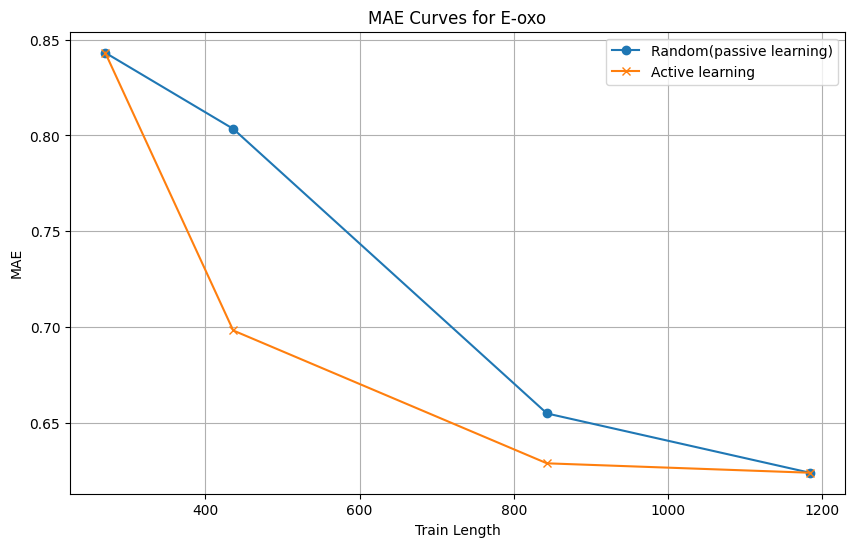

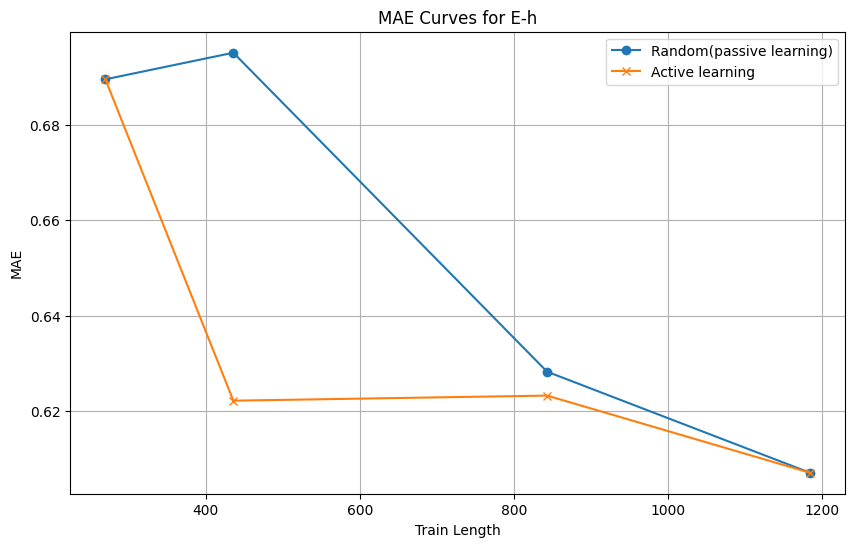

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df1 and df2 are your DataFrames
# Example DataFrames (replace with your actual DataFrames)

for prop in ["oxo", "h"]:
    df1 = pd.read_csv(f"/scratch/yll6162/MOF-oxo/{prop}_rf_al_random.csv")
    df2 = pd.read_csv(f"/scratch/yll6162/MOF-oxo/{prop}_rf_al_sort.csv")
    # Extract columns
    train_length_1 = df1['train_lens']
    mae_1 = df1['maes'].values
    train_length_2 = df2['train_lens']
    mae_2 = df2['maes'].values

    mae_2[-1] = mae_1[-1]

    # Plot MAE curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_length_1, mae_1, label='Random(passive learning)', marker='o')
    plt.plot(train_length_2, mae_2, label='Active learning', marker='x')
    # plt.plot(train_length_1, mae_1, label='Random(passive learning)', marker=None)
    # plt.plot(train_length_2, mae_2, label='Active learning', marker=None)

    # Add titles and labels
    plt.title(f'MAE Curves for E-{prop}')
    plt.xlabel('Train Length')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()
